# **Machine Learning - Exercise 3 (WS 2022)**
**Group (31):** Petkova Violeta (01636660), Upadhyaya Bishal (12119246), Gabor Toaso (12127079)

**Model name:** Single-layer using LSTM128 and 20 epochs

In [95]:
import os
from bs4 import BeautifulSoup
import string
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers.core import Dense, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
import pickle
from keras.optimizers import RMSprop
import numpy as np
from numpy import array
import heapq
import matplotlib.pyplot as plt
import matplotlib

**Import "title" data from files 000-007**

In [96]:
# By defining the nam of the model, this is inherited to other deliverables
name="Single_layer_LSTM128_20epochs"

# Importing "title"s from documents (00-07)
documents = []
for file in os.listdir("reuters_sample/"): # original: "reuters_data/"
    if file.endswith('.sgm'): # it is important for GoogleColab
        filename = os.path.join("reuters_sample", file) # original: "reuters_data"
        f = open(filename, 'r', encoding='utf-8', errors='ignore')
        dataFile = f.read().lower()
        
        soup = BeautifulSoup(dataFile, 'html.parser')
        contents = soup.findAll('title')
        
        for content in contents:
            documents.append(content.text)

In [97]:
# Print the number of documents
print('Number of documents: {}'.format(len(documents)))

Number of documents: 7958


In [98]:
# Remove duplicated strings from the list of strings
documents = [i for n, i in enumerate(documents) if i not in documents[:n]]
print('Number of documents: {}'.format(len(documents)))

Number of documents: 7693


In [99]:
# Print the first 10 candidates from document
documents[:10]

['fairfax says higher tax hits first half earnings',
 'bank of france sells 1.6 billion francs crh tap',
 'britoil plc <btol.l> 1986 yr',
 'uk unit wage/labour costs rose 3.3 pct in three months ending jan - official\n',
 'uk average earnings rose 7.6 pct in january, underlying rise 7.5 pct - official\n',
 'u.k. february adjusted sterling m3 rises 2-1/4 pct, m0 down 3/4 to one pct - official\n',
 'legal and general group plc year 1986',
 'feb sterling bank lending up 2.9 billion stg after 1.75 rise in jan - official\n',
 'uk feb adjusted unemployment fell 44,100 total 3.07 mln or 11.1 pct - official\n',
 'japan to ask chip makers to slash output further']

**Join the documents**

In [100]:
# Join imported documents (00-07)
data = ""
for d in documents:
    data += d

In [101]:
# Print the number of data
print('Number of data: {}'.format(len(data)))

Number of data: 347403


In [102]:
# improve punctuation
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '')
print('Number of data: {}'.format(len(data)))
print(data[:100])

Number of data: 346768
fairfax says higher tax hits first half earningsbank of france sells 1.6 billion francs crh tapbrito


In [103]:
# map punctuation to space
translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
data = data.translate(translator)
print(data[:100])

fairfax says higher tax hits first half earningsbank of france sells 1 6 billion francs crh tapbrito


In [104]:
# integer encode text
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])
encoded_data = tokenizer.texts_to_sequences([data])[0]
print(len(encoded_data))
encoded_data[:5]

51500


[2236, 12, 113, 64, 934]

In [105]:
# determine the vocabulary size
# unique_words = tokenizer.word_index
unique_words = np.unique(encoded_data)
vocab_size = len(unique_words) + 1  # 0 is reserved for padding so that's why we added 1
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 14409


**We need to create sequences of words to fit the model.**

In [106]:
# create word -> word sequences
WORD_LENGTH = 5
prev_words = []
next_words = []
for i in range(1, len(encoded_data) - WORD_LENGTH):
    prev_words.append(encoded_data[i:i + WORD_LENGTH])
    next_words.append(encoded_data[i + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])

[12, 113, 64, 934, 134]
470


In [107]:
# Print the size of the sequence
print('Total Sequences: %d' % len(prev_words))

Total Sequences: 51494


In [108]:
# list(len(prev_words)[:5]) # [input, output]



**We can then split the sequences into input (X) and output elements (y)**



In [109]:
# split into X and y elements
X = prev_words
X = np.array(X)
Y = next_words
Y = np.array(Y)

# X = np.zeros((len(prev_words), WORD_LENGTH, vocab_size), dtype=bool)
# Y = np.zeros((len(next_words), vocab_size), dtype=bool)

In [110]:
print(X[:5])
print(Y[:5])

[[  12  113   64  934  134]
 [ 113   64  934  134  470]
 [  64  934  134  470 3708]
 [ 934  134  470 3708    8]
 [ 134  470 3708    8  387]]
[ 470 3708    8  387   35]


In [111]:
# one hot encode outputs
Y = to_categorical(Y, num_classes=vocab_size)
# define model
Y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [112]:
X.shape
Y.shape

(51494, 14409)

**Build the model**

In [113]:
model = Sequential()
model.add(Embedding(vocab_size, 5, input_length=5)) # original: 5
model.add(LSTM(128))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 5, 5)              72045     
                                                                 
 lstm_5 (LSTM)               (None, 128)               68608     
                                                                 
 dense_3 (Dense)             (None, 14409)             1858761   
                                                                 
Total params: 1,999,414
Trainable params: 1,999,414
Non-trainable params: 0
_________________________________________________________________
None


**Train the model**

In [114]:
# fit network
# optimizer = RMSprop(learning_rate=0.01) # deactivated optimizer

# compile network
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

Epoch 1/20
383/383 [==============================] - 30s 74ms/step - loss: 8.4126 - accuracy: 0.0287 - val_loss: 8.4099 - val_accuracy: 0.0276
Epoch 2/20
383/383 [==============================] - 28s 72ms/step - loss: 7.9192 - accuracy: 0.0291 - val_loss: 8.5514 - val_accuracy: 0.0276
Epoch 3/20
383/383 [==============================] - 29s 77ms/step - loss: 7.7824 - accuracy: 0.0297 - val_loss: 8.6583 - val_accuracy: 0.0276
Epoch 4/20
383/383 [==============================] - 27s 71ms/step - loss: 7.6598 - accuracy: 0.0383 - val_loss: 8.7326 - val_accuracy: 0.0412
Epoch 5/20
383/383 [==============================] - 27s 70ms/step - loss: 7.5058 - accuracy: 0.0464 - val_loss: 8.6136 - val_accuracy: 0.0485
Epoch 6/20
383/383 [==============================] - 28s 72ms/step - loss: 7.3267 - accuracy: 0.0527 - val_loss: 8.5709 - val_accuracy: 0.0548
Epoch 7/20
383/383 [==============================] - 27s 70ms/step - loss: 7.1505 - accuracy: 0.0584 - val_loss: 8.7715 - val_accuracy:

In [115]:
# After successful training, we will save the trained model and just load it back as needed.
model.save('keras_next_word_model'+str(name)+'.h5')
pickle.dump(history, open('history'+str(name)+'.p', 'wb'))

In [116]:
# Loading back the saved weights and history
model = load_model('keras_next_word_model'+str(name)+'.h5')
history = pickle.load(open('history'+str(name)+'.p', 'rb'))

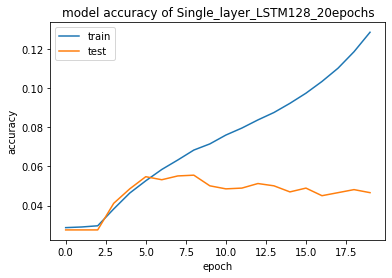

In [117]:
# Evaluation (accuracy)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy of '+str(name))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc= 'upper left')

plt.savefig("01.Accuracy"+str(name)+".png")

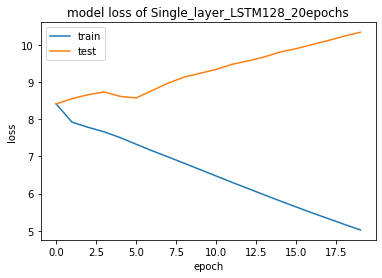

In [118]:
# Evaluation (loss)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss of ' +str(name))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc= 'upper left')

plt.savefig("02.Loss"+str(name)+".png")

In [120]:
## 10 TITLE EXAMPLES FOR EVALUATION:
"""
'farmers concerned about british sugar ownership'
'satellite auction unit march, april bookings up'
'winland electronics inc 4th qtr loss'
'sapporo breweries issues five year sfr notes'
'report due on oil imports and national security'
'continental air february load factor falls'
'great american issues 15 billion yen eurobond'
'paribas shares to be quoted on main paris market'
'salomon sells 200 mln stg mortgages-backed notes'
'opec says february output under ceiling'
"""

max_sequence_len=6
seed_text = "continental air february "
next_words = 1
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    #predicted = model.predict_classes(token_list, verbose=0)
    predict_x=model.predict(token_list) 
    predicted=np.argmax(predict_x,axis=1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

1/1 [==============================] - 0s 97ms/step
continental air february  in
